In [1]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

## Approach

In order to optimize marketing campaigns with the help of the dataset, we will have to take the following steps:
1. Import data from dataset and perform initial high-level analysis: look at the number of rows, look at the missing values, look at dataset columns and their values respective to the campaign outcome.
2. Clean the data: remove irrelevant columns, deal with missing and incorrect values, turn categorical columns into dummy variables.
3. Use machine learning techniques to predict the marketing campaign outcome and to find out factors, which affect the success of the campaign.

## Import Data

First of all to perform the analysis, we have to import the data:

In [2]:
#import dataset

df = pd.read_csv('bank.csv')
term_deposits = df.copy()

In [3]:
df.head()
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

## Data Exploration

After we imported the dataset, we have to look at the total number of rows in the dataset and analyze the number of missing values.

In [4]:
# number of rows in dataset

print("Bank marketing dataset consists of {rows} rows.".format(rows = len(df)))

Bank marketing dataset consists of 11162 rows.


In [5]:
#find percentage of missing values for each column
missing_values = df.isnull().mean()*100

missing_values.sum()

0.0

So we see that there are no missing values.

### Categorical columns exploration

In the dataset we have both categorical and numerical columns. Let's look at the values of categorical columns first.

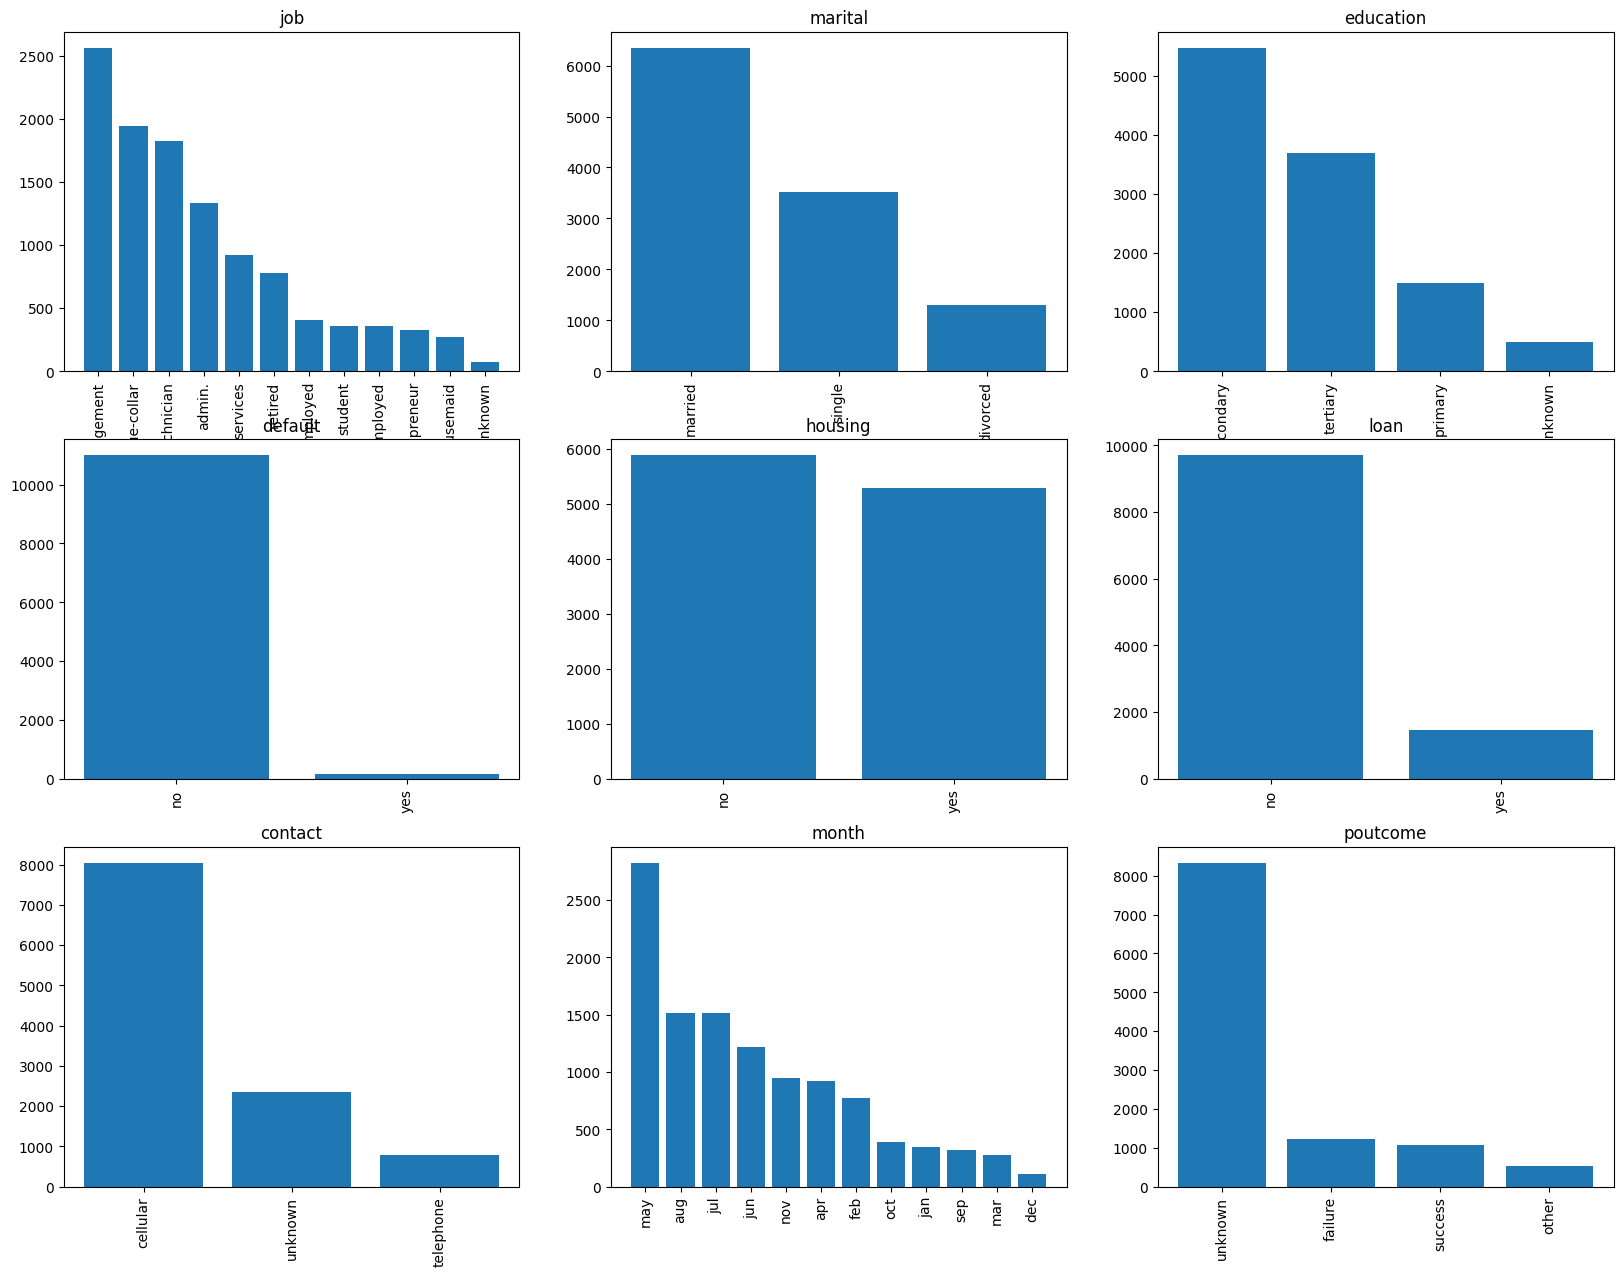

In [6]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()

    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))

    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)

    axs[trace_x, trace_y].set_title(cat_column)

    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)

    counter += 1

plt.show()

### Numerical columns exploration

Now let's look at the numerical columns' values. The most convenient way to look at the numerical values is plotting histograms.

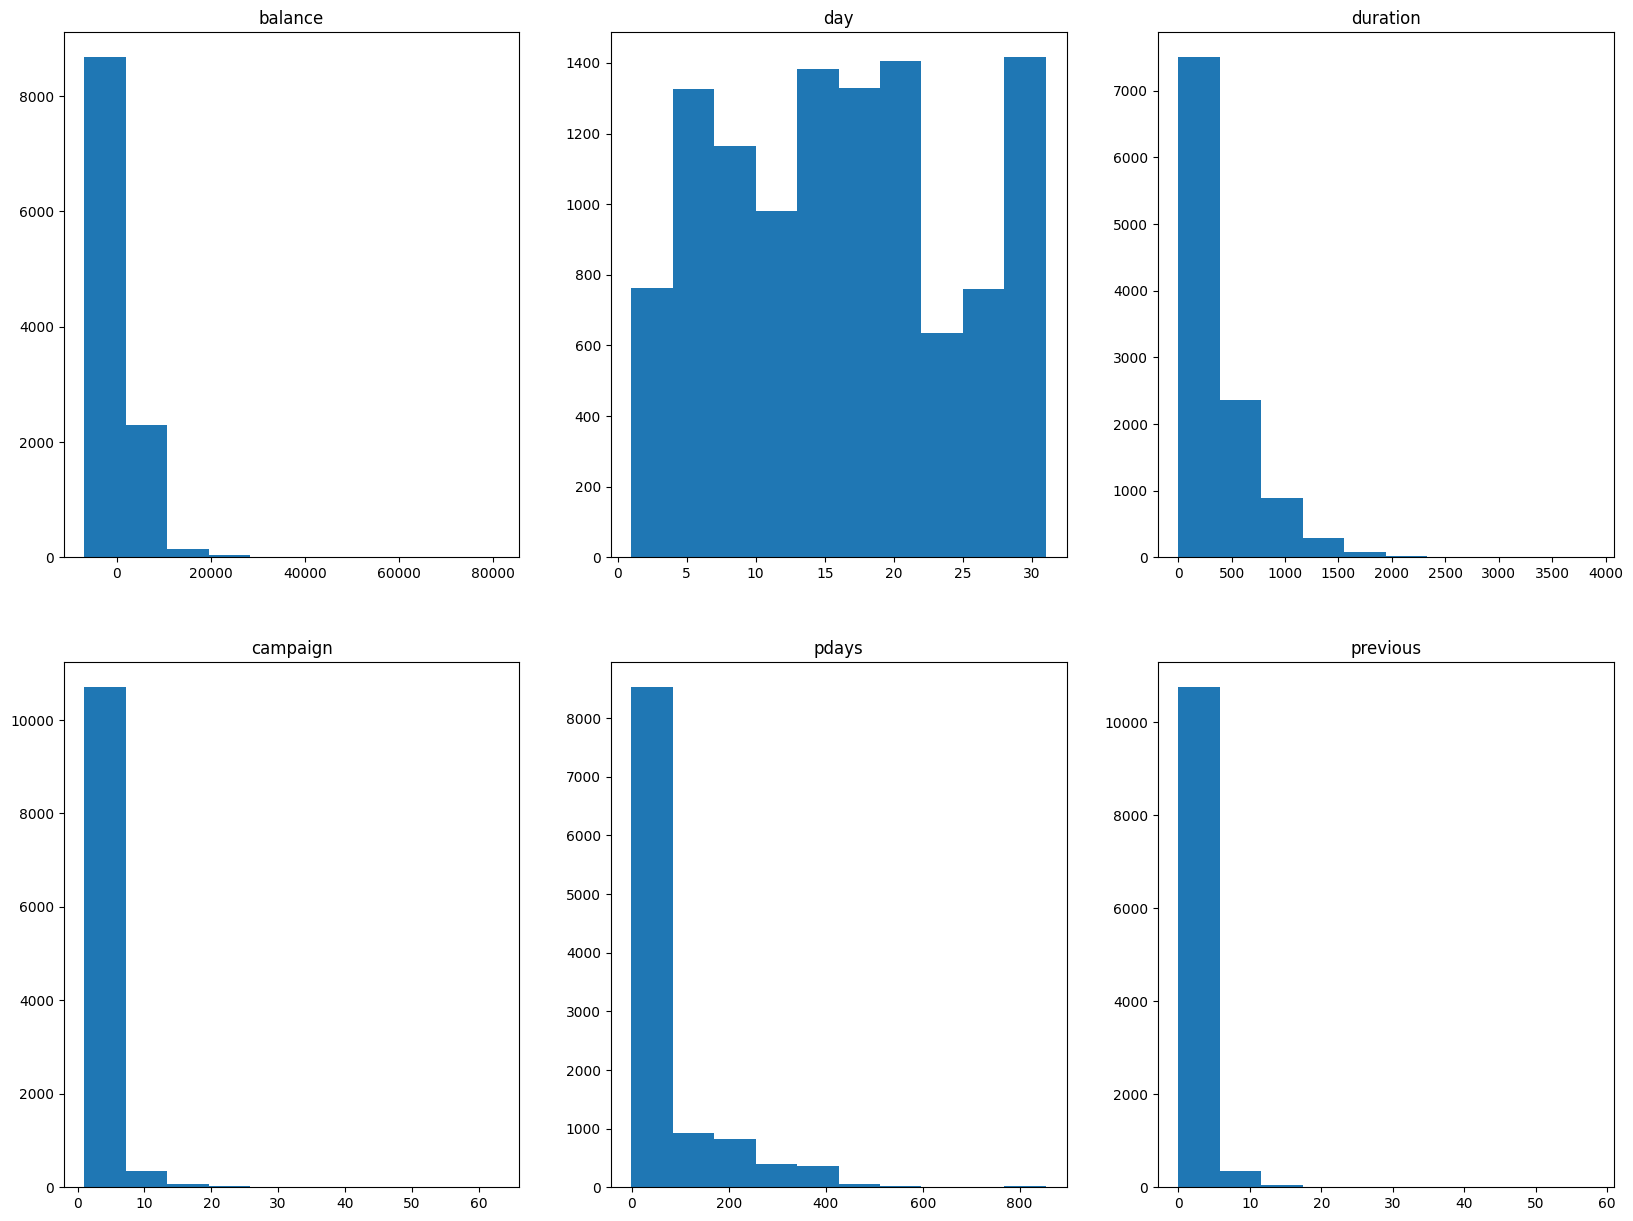

In [7]:
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for num_column in num_columns:

    trace_x = counter // 3
    trace_y = counter % 3

    axs[trace_x, trace_y].hist(df[num_column])

    axs[trace_x, trace_y].set_title(num_column)

    counter += 1

plt.show()

We can see that numerical columns have outliers (especially 'pdays', 'campaign' and 'previous' columns). Possibly there are incorrect values (noisy data), so we should look closer at the data and decide how do we manage the noise.
<br> Let's look closer at the values of 'campaign', 'pdays' and 'previous' columns:

In [8]:
df[['pdays', 'campaign', 'previous']].describe()

,pdays,campaign,previous
count,11162.000000,11162.000000,11162.000000
mean,51.330407,2.508421,0.832557
std,108.758282,2.722077,2.292007
min,-1.000000,1.000000,0.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,20.750000,3.000000,1.000000
max,854.000000,63.000000,58.000000


Percentage of 'pdays' values above 400:

In [9]:
len (df[df['pdays'] > 400] ) / len(df) * 100

1.2005017022039062

'pdays' holds the number of days that passed by after the client was last contacted from a previous campaign
Looking closer into 'pdays' data we can see that:
* only 1.2% of values above 400. They are possibly outliers, so we should consider imputing something (possibly mean value) instead of these values.
* -1 possibly means that the client wasn't contacted before or stands for missing data.

Since we are not sure exactly what -1 means I suggest to drop this column, because -1 makes more than 50% of the values of the column.

Percentage of 'campaign' values above 20:

In [10]:
len (df[df['campaign'] > 34] ) / len(df) * 100

0.035835871707579285

'campaign' holds the number of contacts performed during this campaign and for this client (numeric, includes last contact)
Numbers for 'campaign' above 34 are clearly noise, so I suggest to impute them with average campaign values while data cleaning.

Percentage of 'previous' values above 20:

In [11]:
len (df[df['previous'] > 34] ) / len(df) * 100

0.04479483963447411

'previous' holds the number of contacts performed before this campaign and for this client (numeric)
Numbers for 'previous' above 34 are also really strange, so I suggest to impute them with average campaign values while data cleaning.

### Analysis of the response column

It is very important to look at the response column, which holds the information, which we are going to predict. In our case we should look at 'deposit' column and compare its values to other columns.
<br> First of all we should look at the number of 'yes' and 'no' values in the response column 'deposit'.

<Axes: title={'center': 'Deposit value counts'}, xlabel='deposit'>

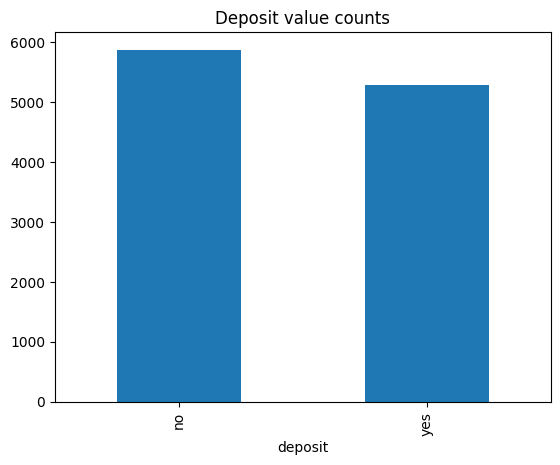

In [12]:
value_counts = df['deposit'].value_counts()

value_counts.plot.bar(title = 'Deposit value counts')

On the diagram we see that counts for 'yes' and 'no' values for 'deposit' are close, so we can use accuracy as a metric for a model, which predicts the campaign outcome.

Let's see how 'deposit' column value varies depending on other categorical columns' values:

<Axes: title={'center': 'Job and deposit'}, xlabel='job'>

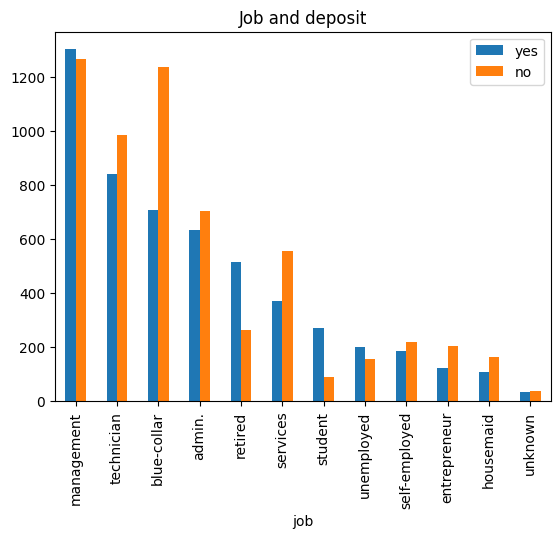

In [13]:
#job and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Job and deposit')

<Axes: title={'center': 'Marital status and deposit'}, xlabel='marital'>

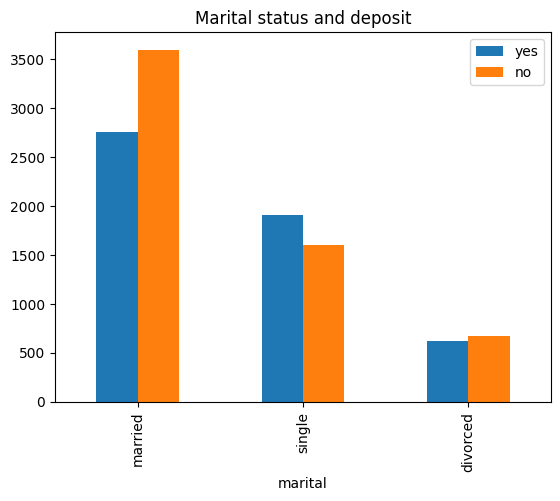

In [14]:
#marital status and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')

<Axes: title={'center': 'Education and deposit'}, xlabel='education'>

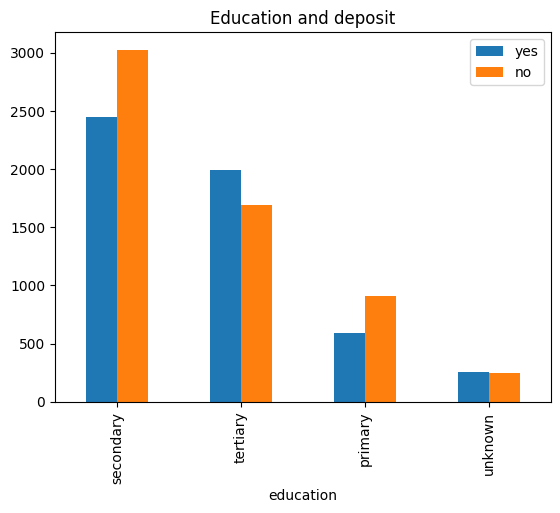

In [15]:
#education and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Education and deposit')

<Axes: title={'center': 'Type of contact and deposit'}, xlabel='contact'>

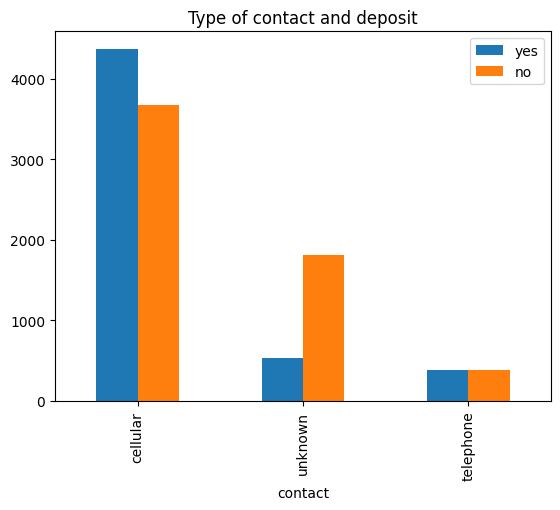

In [16]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Type of contact and deposit')

Regarding the diagrams we can tell that according to our dataset:
1. Customers with 'blue-collar' and 'services' jobs are less likely to subscribe for term deposit.
2. Married customers are less likely to subscribe for term deposit.
3. Customers with 'cellular' type of contact are less likely to subscribe for term deposit.

Now let's look how numerical columns affect term deposit subscription.

In [17]:
#balance and deposit

b_df = pd.DataFrame()
b_df['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
b_df['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']

b_df

,balance_yes,balance_no
count,5289.000000,5873.000000
mean,1804.267915,1280.227141
std,3501.104777,2933.411934
min,-3058.000000,-6847.000000
25%,210.000000,64.000000
50%,733.000000,414.000000
75%,2159.000000,1324.000000
max,81204.000000,66653.000000


<Axes: title={'center': 'Balance and deposit statistics'}>

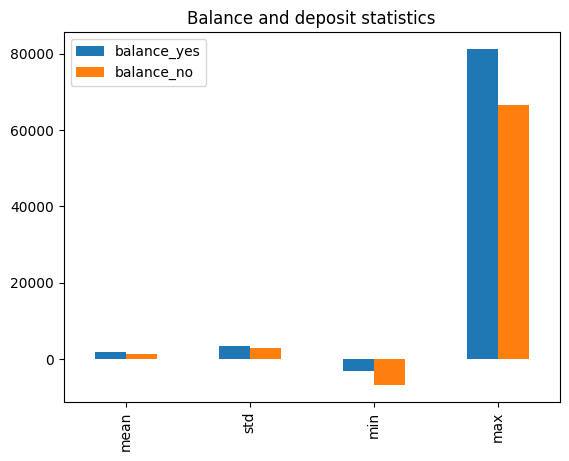

In [18]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance and deposit statistics')

In [19]:
#age and deposit

a_df = pd.DataFrame()
a_df['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
a_df['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']

a_df

,age_yes,age_no
count,5289.000000,5873.000000
mean,41.670070,40.837391
std,13.497781,10.264815
min,18.000000,18.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,89.000000


<Axes: title={'center': 'Age and deposit statistics'}>

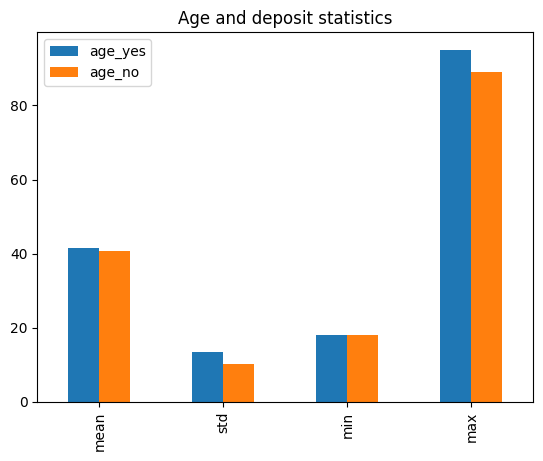

In [20]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age and deposit statistics')

In [21]:
#number of contacts performed during this campaign ('campaign') and deposit
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

c_df

,campaign_yes,campaign_no
count,5289.000000,5873.000000
mean,2.141047,2.839264
std,1.921826,3.244474
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,32.000000,63.000000


<Axes: title={'center': 'Number of contacts performed during this campaign and deposit statistics'}>

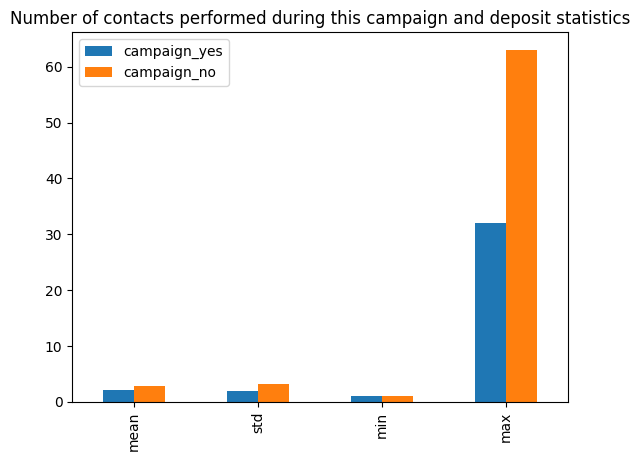

In [22]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during this campaign and deposit statistics')

In [23]:
#number of contacts performed during previous campaign ('previous') and deposit
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
p_df['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']

p_df

,previous_yes,previous_no
count,5289.000000,5873.00000
mean,1.170354,0.52835
std,2.553272,1.97961
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,1.000000,0.00000
max,58.000000,41.00000


<Axes: title={'center': 'Number of contacts performed during previous campaign and deposit statistics'}>

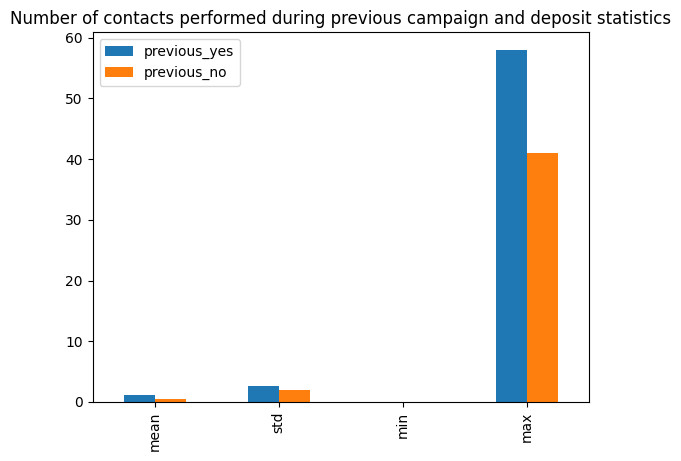

In [24]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during previous campaign and deposit statistics')

Looking at the diagrams above we can conclude that:
1. People who subscribed for term deposit tend to have greater balance and age values.
2. People who subscribed for term deposit tend to have fewer number of contacts during this campaign.

## Data Cleaning

Before we will be able to apply machine learning techniques, we should prepare the dataset for processing:
1. Convert columns with 'yes' and 'no' values to boolean columns;
2. Convert categorical columns into dummy variables.

In [25]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset

    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    '''

    cleaned_df = df.copy()

    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)

    cleaned_df = cleaned_df.drop(columns = bool_columns)

    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)

    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])

    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)

    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])

    return cleaned_df

In [26]:
#clean the dataset
cleaned_df = clean_data(df)
cleaned_df.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,deposit_bool,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned
0,59,2343,5,1042,0,1,0,1,False,False,...,False,True,False,False,False,False,False,True,1.0,0.0
1,56,45,5,1467,0,0,0,1,False,False,...,False,True,False,False,False,False,False,True,1.0,0.0
2,41,1270,5,1389,0,1,0,1,False,False,...,False,True,False,False,False,False,False,True,1.0,0.0
3,55,2476,5,579,0,1,0,1,False,False,...,False,True,False,False,False,False,False,True,1.0,0.0
4,54,184,5,673,0,0,0,1,False,False,...,False,True,False,False,False,False,False,True,2.0,0.0


# Checking missing independence for catagorical variables.

In [27]:
from scipy.stats import chi2_contingency

# List of categorical columns
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
target_col = 'deposit'

# Iterate through each categorical column and perform Chi-Square test
for col in cat_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(df[col], df[target_col])

    # Perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print results
    print(f"Chi-Square Test for {col} and {target_col}:")
    print(f"Chi2 Statistic: {chi2:.2f}, P-value: {p:.4f}, Degrees of Freedom: {dof}")
    if p < 0.05:
        print("=> Significant association (Reject Null Hypothesis)")
    else:
        print("=> No significant association (Fail to Reject Null Hypothesis)")
    print("-" * 50)


Chi-Square Test for job and deposit:
Chi2 Statistic: 378.08, P-value: 0.0000, Degrees of Freedom: 11
=> Significant association (Reject Null Hypothesis)
--------------------------------------------------
Chi-Square Test for marital and deposit:
Chi2 Statistic: 109.58, P-value: 0.0000, Degrees of Freedom: 2
=> Significant association (Reject Null Hypothesis)
--------------------------------------------------
Chi-Square Test for education and deposit:
Chi2 Statistic: 122.77, P-value: 0.0000, Degrees of Freedom: 3
=> Significant association (Reject Null Hypothesis)
--------------------------------------------------
Chi-Square Test for default and deposit:
Chi2 Statistic: 17.81, P-value: 0.0000, Degrees of Freedom: 1
=> Significant association (Reject Null Hypothesis)
--------------------------------------------------
Chi-Square Test for housing and deposit:
Chi2 Statistic: 463.19, P-value: 0.0000, Degrees of Freedom: 1
=> Significant association (Reject Null Hypothesis)
------------------

## Machine Learning for prediction of campaign outcome

### Classification model for the campaign outcome prediction

Create X and y datasets for training the model and split into train and test datasets.

In [28]:
X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]

In [29]:
TEST_SIZE = 0.3
RAND_STATE = 42

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)


In [31]:
# Time for Classification Models
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

dict_classifiers = {

    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=18),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB()
}

In [32]:
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.process_time()
        classifier.fit(X_train, Y_train)
        t_end = time.process_time()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [33]:
df_results = batch_classify(X_train, y_train.values.ravel())
print(df_results.sort_values(by='train_score', ascending=False))

<ipython-input-32-0c88d4c996a7>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Nearest Neighbors' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results.loc[count,'classifier'] = key


trained Nearest Neighbors in 0.01 s
trained Linear SVM in 4.95 s
trained Gradient Boosting Classifier in 2.18 s
trained Decision Tree in 0.10 s
trained Random Forest in 0.30 s
trained Neural Net in 3.23 s
trained Naive Bayes in 0.02 s
                     classifier  train_score  training_time
3                 Decision Tree     1.000000       0.100152
4                 Random Forest     0.997568       0.303120
2  Gradient Boosting Classifier     0.858825       2.176055
5                    Neural Net     0.803405       3.227217
0             Nearest Neighbors     0.797389       0.013910
6                   Naive Bayes     0.731345       0.022018
1                    Linear SVM     0.724818       4.946678


### Avoiding Overfitting:
How can we avoid Overfitting?<br>
The best alternative to avoid overfitting is to use cross validation. Taking the training test and splitting it. For instance, if we split it by 3, 2/3 of the data or 66% will be used for training and 1/3 33% will be used or testing and we will do the testing process three times. This algorithm will iterate through all the training and test sets and the main purpose of this is to grab the overall pattern of the data.


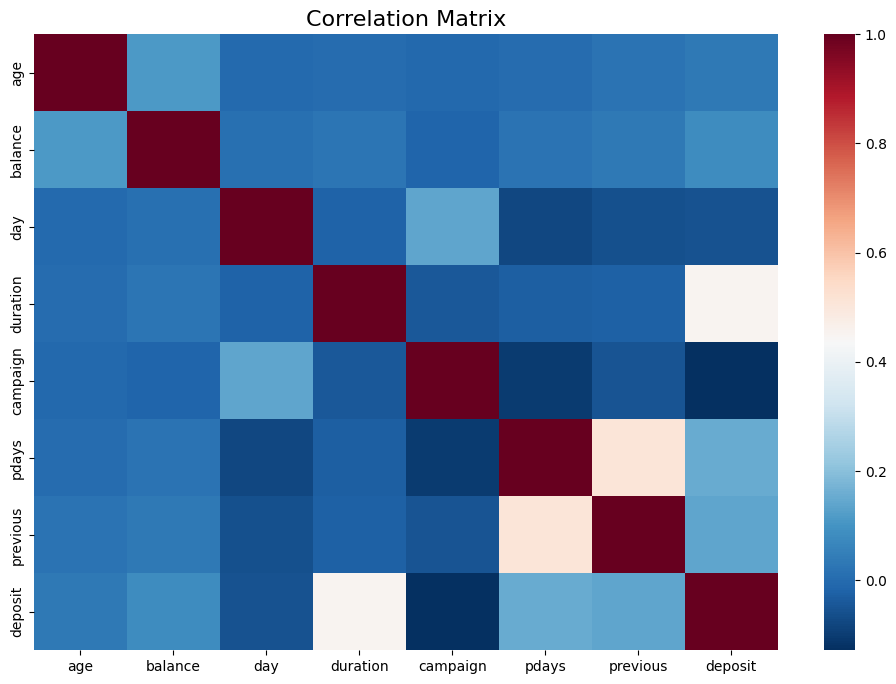

In [34]:
# Let's drop marital/education and balance status
# Let's scale both numeric and categorical vaues
# Then let's use a correlation matrix
# With that we can determine if duration has influence on term deposits

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
fig = plt.figure(figsize=(12,8))
df['deposit'] = LabelEncoder().fit_transform(df['deposit'])



# Separate both dataframes into
numeric_df = df.select_dtypes(exclude="object")
# categorical_df = df.select_dtypes(include="object")

corr_numeric = numeric_df.corr()


sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [35]:
# Use Cross-validation.
from sklearn.model_selection import cross_val_score
y_train=y_train.values.ravel()
# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': [ 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'],
    'Crossval Mean Scores': [svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

In [36]:
# All our models perform well but I will go with GradientBoosting.
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
3,Grad B CLF,0.844363
4,Rand FC,0.837963
2,Dec Tree,0.782541
5,Neural Classifier,0.757457
6,Naives Bayes,0.757457
0,SVC,0.719570
1,KNN,0.709458


# Finding metrics

In [37]:
# Cross validate our Gradient Boosting Classifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)

In [38]:
from sklearn.metrics import accuracy_score
grad_clf.fit(X_train, y_train)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_train, y_train_pred))
y_test_pred=grad_clf.predict(X_test)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_test, y_test_pred))

Gradient Boost Classifier accuracy is 0.84
Gradient Boost Classifier accuracy is 0.84


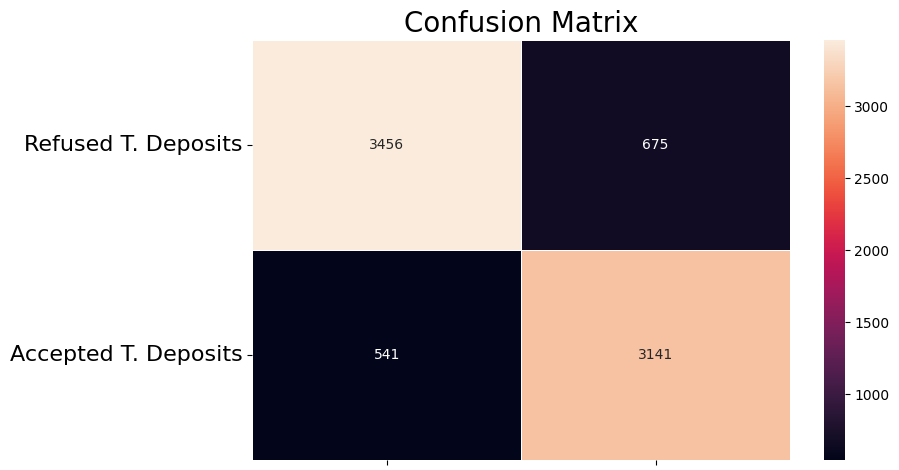

In [39]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show()

In [40]:
# Let's find the scores  for precision and recall.
from sklearn.metrics import precision_score, recall_score
# The model is 77% sure that the potential client will suscribe to a term deposit.
# The model is only retaining 60% of clients that agree to suscribe a term deposit.
print('Precision Score: ', precision_score(y_train, y_train_pred))
# The classifier only detects 60% of potential clients that will suscribe to a term deposit.
print('Recall Score: ', recall_score(y_train, y_train_pred))

Precision Score:  0.8231132075471698
Recall Score:  0.8530689842476915


In [41]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.8378234195785543

In [42]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Gradient Boosting Classifier

y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=3, method="decision_function")



grd_fpr, grd_tpr, thresold = roc_curve(y_train, y_scores)


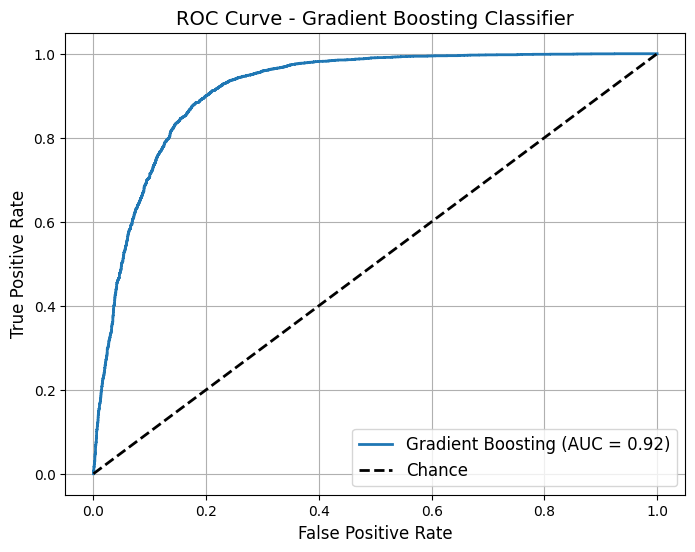

In [43]:
# Calculate AUC
roc_auc = auc(grd_fpr, grd_tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(grd_fpr, grd_tpr, label=f"Gradient Boosting (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", linewidth=2, label="Chance")

plt.title("ROC Curve - Gradient Boosting Classifier", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

In [44]:
print('Gradient Boost Classifier Score: ', roc_auc_score(y_train, y_scores))

Gradient Boost Classifier Score:  0.9156024236667394


# Applying methods to tune the model performance and hyperparameters tuning

- Stratified K-folds
- GridSearchCV (hyperparamenters tuning)

In [45]:
# Define hyperparameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Initialize Stratified K-Folds
strat_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier(random_state=42)

# Perform Grid Search with Stratified K-Folds
grid_search = GridSearchCV(estimator=grad_clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=strat_kfold,
                           n_jobs=-1,
                           verbose=2)

In [46]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=2)

Training & Evaluation after Kfolds and hyperparameters tuning.

In [47]:
# Train the model with the best parameters
best_grad_clf = grid_search.best_estimator_
best_grad_clf.fit(X_train, y_train)

# Predict on the validation set
y_train_pred = best_grad_clf.predict(X_train)
y_test_pred = best_grad_clf.predict(X_test)

# Evaluate the model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))

Training Accuracy: 0.9353641366952515
Test Accuracy: 0.8536876679605853
Precision: 0.8306690349319124
Recall: 0.8730553827006845
F1 Score: 0.8513349514563107


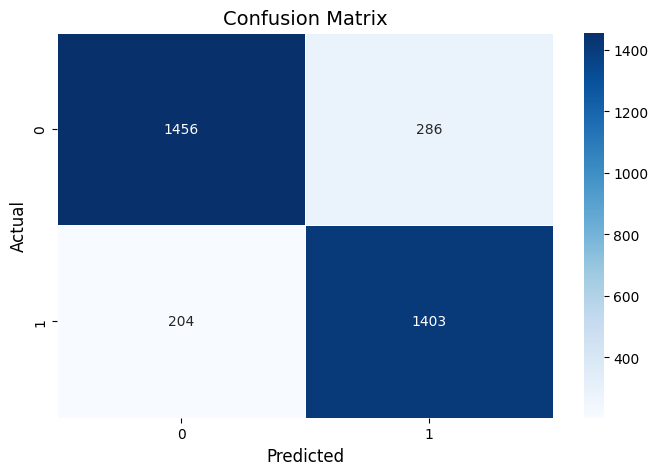

In [48]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap='Blues')
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

In [49]:
# ROC-AUC
y_test_scores = best_grad_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_scores)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9200655570455605


In [50]:
# Get the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Score: 0.8579290387444681


# Which Features Influence the Result of a Term Deposit Suscription?
## DecisionTreeClassifier:
<a id="decision"></a>
The top three most important features for our classifier are **Duration (how long it took the conversation between the sales representative and the potential client), contact (number of contacts to the potential client within the same marketing campaign),house.

Feature ranking:
1. feature 11 (0.591310)
2. feature 8 (0.129966)
3. feature 6 (0.067020)
4. feature 13 (0.049923)
5. feature 15 (0.038138)
6. feature 14 (0.037830)
7. feature 10 (0.026646)
8. feature 5 (0.025842)
9. feature 0 (0.017757)
10. feature 12 (0.007889)
11. feature 3 (0.005280)
12. feature 9 (0.002200)
13. feature 2 (0.000147)
14. feature 1 (0.000050)
15. feature 7 (0.000000)
16. feature 4 (0.000000)


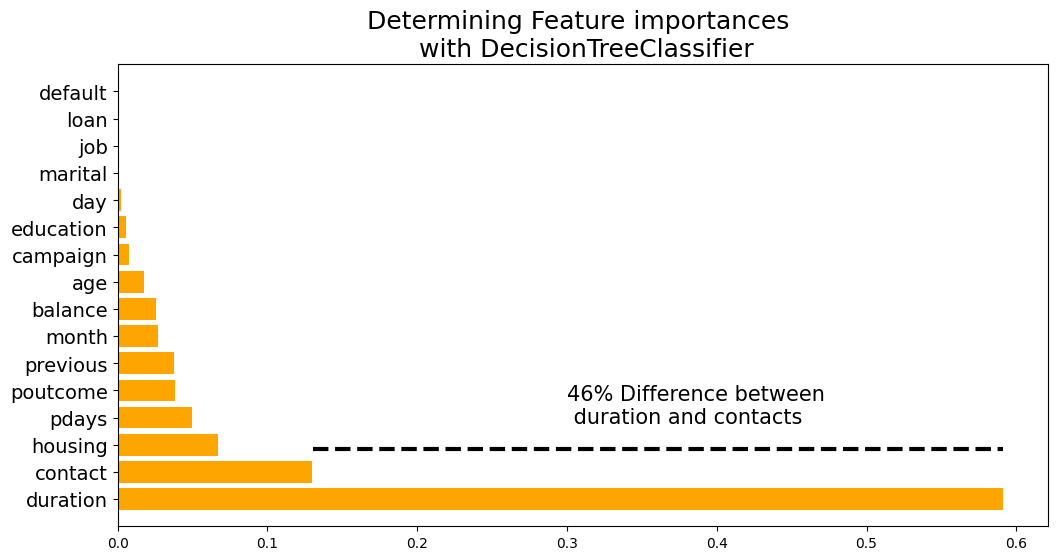

In [51]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


# Convert the columns into categorical variables
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

# Let's create new splittings like before but now we modified the data so we need to do it one more time.
# Create train and test splits
target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01

)



tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='orange',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)

feature_importance_graph(indices, importances, feature_names)
plt.show()

Let's try to make more specific recommendations:

### Specific Recommendations

1. Find out account balance, which marketing campaign should focus on:

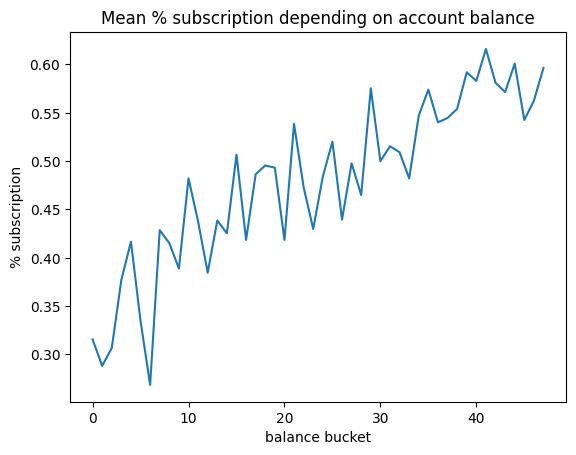

In [52]:
df_new = cleaned_df.copy()

#introduce new column 'balance_buckets' to  ''
df_new['balance_buckets'] = pd.qcut(df_new['balance'], 50, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['balance_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on account balance')
plt.xlabel('balance bucket')
plt.ylabel('% subscription')
plt.show()

In [53]:
df_new[df_new['balance_buckets'] == 34]['balance'].min()

1490

From the diagram above we can conclude, that marketing campaigns should concentrate on customers with account balance greater than 1490$.

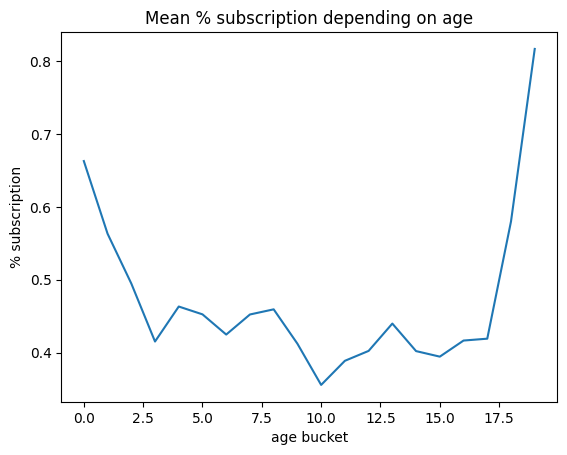

In [54]:
#introduce new column 'age_buckets' to  ''
df_new['age_buckets'] = pd.qcut(df_new['age'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_age = df_new.groupby(['age_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_age.index, mean_age.values)
plt.title('Mean % subscription depending on age')
plt.xlabel('age bucket')
plt.ylabel('% subscription')
plt.show()

In [55]:
df_new[df_new['age_buckets'] == 3]['age'].max()

31

In [56]:
df_new[df_new['age_buckets'] == 17]['age'].min()

56

So we see that average subscrition rate tends to be higher for customers below 31 years old or above 56 years old.

3. Find out appropriate number of contacts with the customer during campaign:

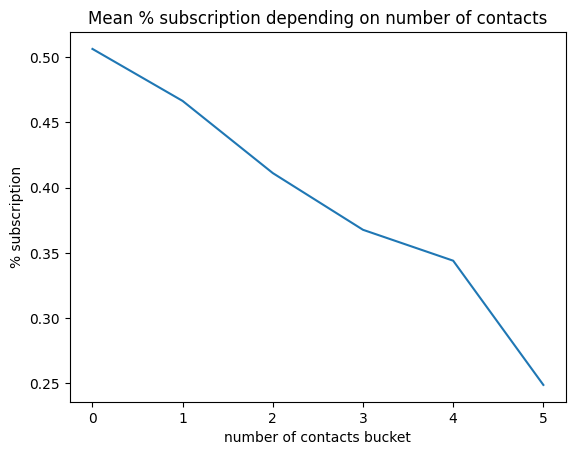

In [57]:
#introduce new column 'age_buckets' to  ''
df_new['campaign_buckets'] = pd.qcut(df_new['campaign_cleaned'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_campaign = df_new.groupby(['campaign_buckets'])['deposit_bool'].mean()

#plot average campaign outcome per bucket
plt.plot(mean_campaign.index, mean_campaign.values)
plt.title('Mean % subscription depending on number of contacts')
plt.xlabel('number of contacts bucket')
plt.ylabel('% subscription')
plt.show()

In [58]:
df_new[df_new['campaign_buckets'] == 2]['campaign_cleaned'].min()

4.0

From the plot above we see that average subscription rate is below 50% if the number of contacts during the campaign exceeds 4.

# Clustering as EDA and Feature Engineering

In [59]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3


In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

In [61]:
# Create dataset for clustering
DS_2_cluster = pd.DataFrame()
DS_2_cluster['age'] = X['age']
DS_2_cluster['education'] = X['education']
DS_2_cluster['marital'] = X['marital']
DS_2_cluster['job'] = X['job']
DS_2_cluster['campaign'] = X['campaign']
DS_2_cluster['balance'] = X['balance']
DS_2_cluster['housing'] = X['housing']
DS_2_cluster['contact'] = X['contact']
DS_2_cluster['label'] = y

data = DS_2_cluster[['age', 'education', 'marital', 'job', 'campaign', 'balance']]
data

,age,education,marital,job,campaign,balance
0,59,1,1,0,1,2343
1,56,1,1,0,1,45
2,41,1,1,9,1,1270
3,55,1,1,7,1,2476
4,54,2,1,0,2,184
...,...,...,...,...,...,...
11157,33,0,2,1,1,1
11158,39,1,1,7,4,733
11159,32,1,2,9,2,29
11160,43,1,1,9,2,0


In [62]:
# Scale the features, fit and transform
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(data)


In [63]:
#Fit and transfrm
data1=X[['housing','contact','duration']]
cluster_scaled_1=scaler.fit_transform(data1)

In [64]:
# Fit KMeans with a specific number of clusters
model = KMeans(n_clusters=4, random_state=42)
model.fit(cluster_scaled)
kmeans_labels = model.labels_

In [65]:
# Add cluster labels to the dataset
DS2_clustered_kmeans = data.assign(Cluster=kmeans_labels)

In [66]:
grouped_kmeans = DS2_clustered_kmeans.groupby(['Cluster']).mean().round(1)

In [67]:
# Silhouette Score for Validation
sil_score = silhouette_score(cluster_scaled, kmeans_labels)
print(f"Silhouette Score for KMeans with 4 clusters: {sil_score:.2f}")

Silhouette Score for KMeans with 4 clusters: 0.20


Low Silhouette Score shows that we have weak clusters.

In [68]:
print("Cluster Means:")
print(grouped_kmeans)

Cluster Means:
          age  education  marital  job  campaign  balance
Cluster                                                  
0        40.7        1.7      0.8  6.1       2.9   1004.6
1        31.9        1.5      2.0  5.4       2.3   1375.9
2        60.2        1.1      0.8  5.4       2.0   4038.0
3        41.5        0.7      1.0  1.1       2.6    950.3


Performing Elbow methods to find the optimal number of clusters

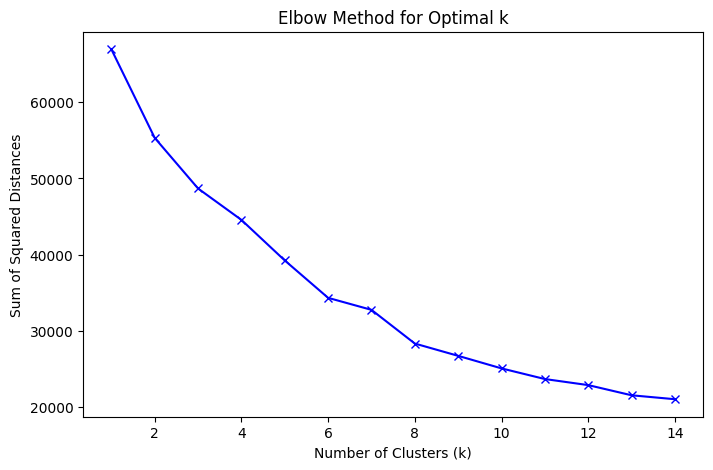

In [69]:
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(cluster_scaled)
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

By using elbow methods we found that 6 number of clusters are optimal for K-Means.

In [70]:
# Refit KMeans with Optimal Number of Clusters (assuming 5 as optimal from the Elbow Plot)
model = KMeans(n_clusters=6, random_state=42)
model.fit(cluster_scaled)
kmeans_labels = model.labels_

In [71]:
# Assign cluster labels to the original dataset and compute group statistics
DS2_clustered_kmeans = data.assign(Cluster=kmeans_labels)
grouped_kmeans = DS2_clustered_kmeans.groupby(['Cluster']).mean().round(1)
print("Cluster Means with 5 Clusters:")
print(grouped_kmeans)

Cluster Means with 5 Clusters:
          age  education  marital  job  campaign  balance
Cluster                                                  
0        40.9        1.7      0.8  6.0       2.2   1188.3
1        32.2        1.6      2.0  6.4       2.1   1239.3
2        59.5        0.8      0.8  5.1       2.1   1634.6
3        38.0        0.8      1.2  0.9       2.1    943.5
4        40.6        1.2      1.2  4.6      13.1    890.6
5        44.1        1.5      1.2  4.9       2.5  17063.6


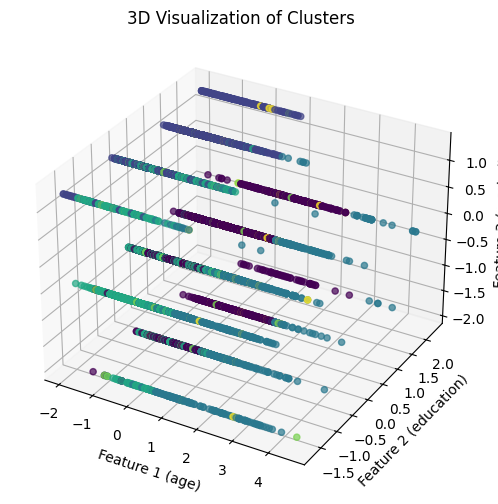

Cluster Counts:
Cluster
0    3271
3    2995
1    2501
2    1790
4     371
5     234
Name: count, dtype: int64


In [72]:
# 3D Visualization of Clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_scaled[:, 0], cluster_scaled[:, 1], cluster_scaled[:, 2], c=kmeans_labels, cmap='viridis', alpha=0.7)
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Feature 1 (age)')
ax.set_ylabel('Feature 2 (education)')
ax.set_zlabel('Feature 3 (marital)')
plt.show()

# Evaluate Clustering Results
cluster_counts = DS2_clustered_kmeans['Cluster'].value_counts()
print("Cluster Counts:")
print(cluster_counts)

3D clusters visualization of 'housing','contact','duration'.

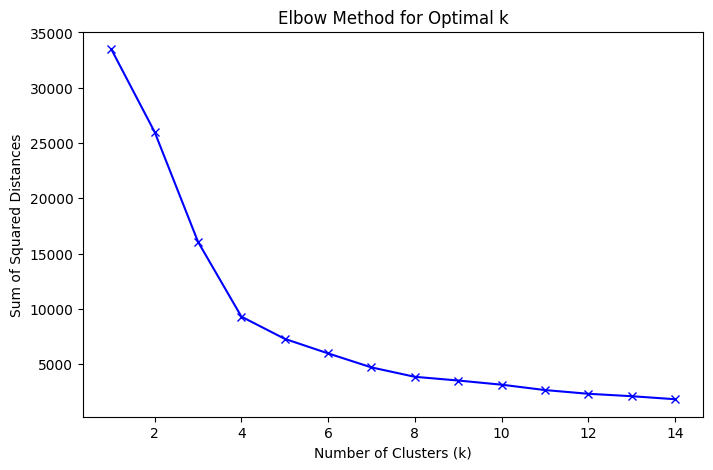

In [73]:
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(cluster_scaled_1)
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

For 'housing', 'contact', 'duration' we found optimal number of clusters to be 4.

In [74]:
# Refit KMeans with Optimal Number of Clusters (assuming 5 as optimal from the Elbow Plot)
model1 = KMeans(n_clusters=4, random_state=42)
model1.fit(cluster_scaled_1)
kmeans_labels = model.labels_

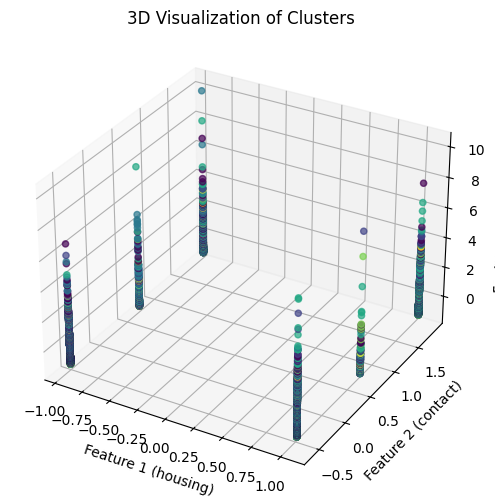

Cluster Counts:
Cluster
0    3271
3    2995
1    2501
2    1790
4     371
5     234
Name: count, dtype: int64


In [75]:
# 3D Visualization of Clusters

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_scaled_1[:, 0], cluster_scaled_1[:, 1], cluster_scaled_1[:, 2], c=kmeans_labels, cmap='viridis', alpha=0.7)
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Feature 1 (housing)')
ax.set_ylabel('Feature 2 (contact)')
ax.set_zlabel('Feature 3 (duration)')
plt.show()

# Evaluate Clustering Results
cluster_counts_1 = DS2_clustered_kmeans['Cluster'].value_counts()
print("Cluster Counts:")
print(cluster_counts_1)

In [76]:
# Silhouette Score for Validation
sil_score = silhouette_score(cluster_scaled, kmeans_labels)
print(f"Silhouette Score for KMeans with 4 clusters: {sil_score:.2f}")

Silhouette Score for KMeans with 4 clusters: 0.22


# **Principle Component Analysis (PCA)**

In [77]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Clean and preprocess the data
cleaned_df = clean_data(df)  # Assuming your 'clean_data' function handles preprocessing

# Define features (X) and target (y)
X = cleaned_df.drop(columns=['deposit_bool'])
y = cleaned_df['deposit_bool']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Explained variance by components: [0.07236681 0.06097307 0.05602295 0.04542376 0.0388118  0.03487297
 0.03273001 0.03143064 0.0303187  0.02905329 0.02766138 0.02744586
 0.02727758 0.02695906 0.02596968 0.02580759 0.02509396 0.02502519
 0.02482085 0.02454794 0.02424003 0.02380206 0.02344546 0.02261215
 0.02168943 0.02150314 0.0208283  0.01980566 0.01946246 0.01876188
 0.01516793 0.01459703 0.01290351]
Number of components: 33


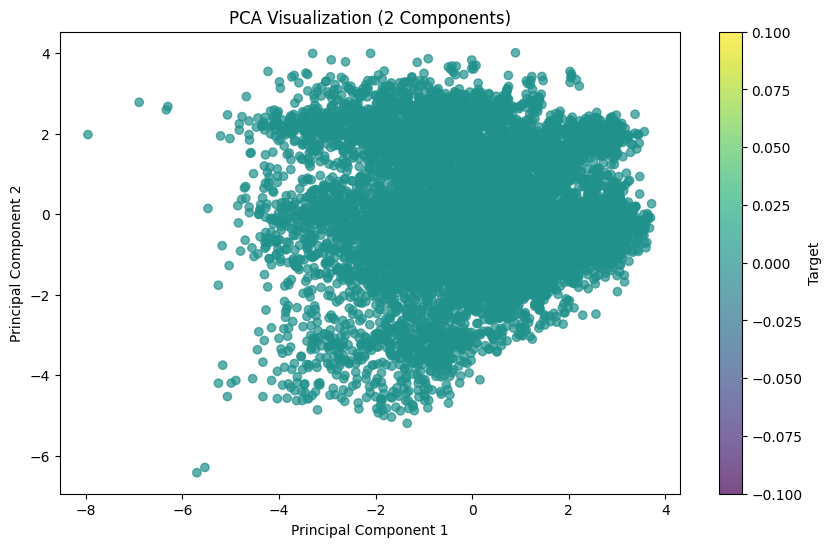

In [78]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Print the explained variance ratio
print("Explained variance by components:", pca.explained_variance_ratio_)
print("Number of components:", pca.n_components_)

# Optional: Visualize the first two components
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Target')
plt.title("PCA Visualization (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [79]:
# Clusterng after PCA

In [80]:
# After PCA Scale the features, fit and transform
scaler_after = StandardScaler()
cluster_scaled = scaler.fit_transform(data)

In [81]:
# Fit KMeans with a specific number of clusters
model = KMeans(n_clusters=4, random_state=42)
model.fit(cluster_scaled)
kmeans_labels = model.labels_

In [82]:
# Silhouette Score for Validation
sil_score = silhouette_score(cluster_scaled, kmeans_labels)
print(f"Silhouette Score for KMeans with 4 clusters: {sil_score:.2f}")

Silhouette Score for KMeans with 4 clusters: 0.20


In [83]:
print("Cluster Means:")
print(grouped_kmeans)

Cluster Means:
          age  education  marital  job  campaign  balance
Cluster                                                  
0        40.9        1.7      0.8  6.0       2.2   1188.3
1        32.2        1.6      2.0  6.4       2.1   1239.3
2        59.5        0.8      0.8  5.1       2.1   1634.6
3        38.0        0.8      1.2  0.9       2.1    943.5
4        40.6        1.2      1.2  4.6      13.1    890.6
5        44.1        1.5      1.2  4.9       2.5  17063.6


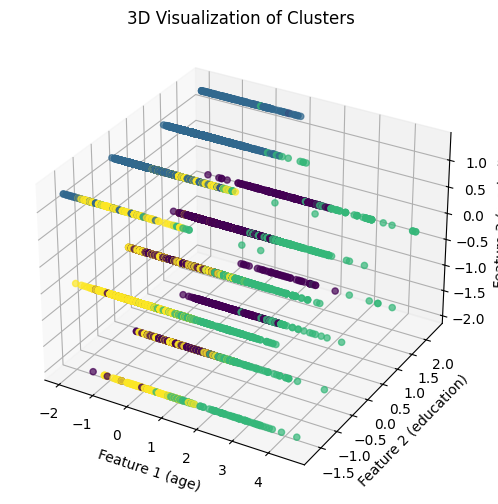

Cluster Counts:
Cluster
0    3271
3    2995
1    2501
2    1790
4     371
5     234
Name: count, dtype: int64


In [84]:
# 3D Visualization of Clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_scaled[:, 0], cluster_scaled[:, 1], cluster_scaled[:, 2], c=kmeans_labels, cmap='viridis', alpha=0.7)
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Feature 1 (age)')
ax.set_ylabel('Feature 2 (education)')
ax.set_zlabel('Feature 3 (marital)')
plt.show()

# Evaluate Clustering Results
cluster_counts = DS2_clustered_kmeans['Cluster'].value_counts()
print("Cluster Counts:")
print(cluster_counts)

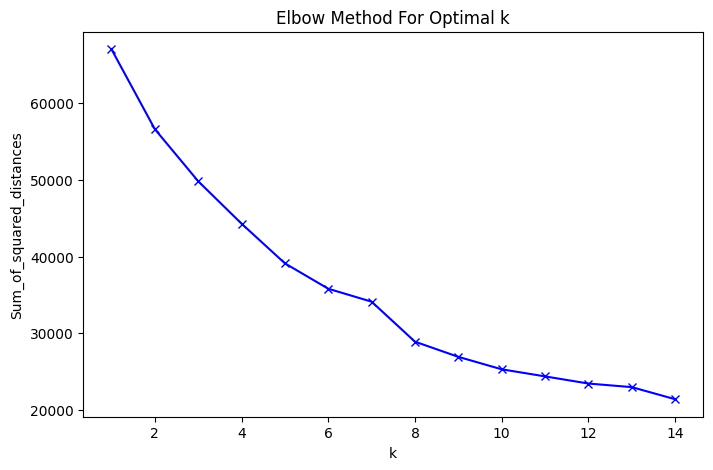

In [85]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_scaled)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure(figsize=(8,5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

After performing PCA we saw a slight difference in our number of optimal clusters and clusters visualization.

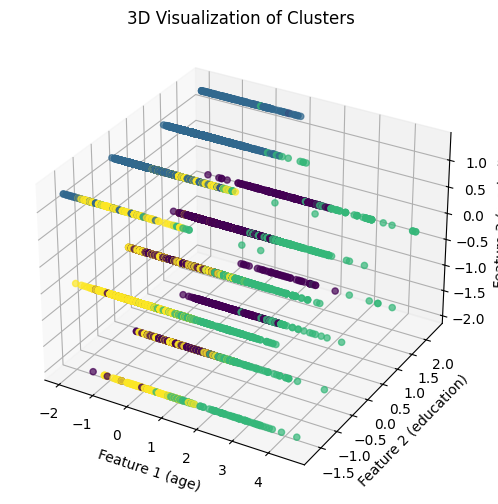

Cluster Counts:
Cluster
0    3271
3    2995
1    2501
2    1790
4     371
5     234
Name: count, dtype: int64


In [86]:
# 3D Visualization of Clusters
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_scaled[:, 0], cluster_scaled[:, 1], cluster_scaled[:, 2], c=kmeans_labels, cmap='viridis', alpha=0.7)
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Feature 1 (age)')
ax.set_ylabel('Feature 2 (education)')
ax.set_zlabel('Feature 3 (marital)')
plt.show()

# Evaluate Clustering Results
cluster_counts = DS2_clustered_kmeans['Cluster'].value_counts()
print("Cluster Counts:")
print(cluster_counts)

In [94]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Fit KMeans with scaled data
model = KMeans(n_clusters=5, random_state=42)
model.fit(cluster_scaled_1)
kmeans_labels = model.labels_

# Ensure `y` is correctly extracted and has 'deposit_bool'
if 'deposit_bool' not in y:
    y = cleaned_df['deposit_bool']  # Extract the column from the original dataframe

# Add labels and cluster assignments
data1['labels'] = y.values  # Use `.values` if y is a Series
DS2_clustered_kmeans = data1.assign(Cluster=kmeans_labels)

# Group by cluster and calculate mean
grouped_kmeans = DS2_clustered_kmeans.groupby(['Cluster']).mean().round(1)
print(grouped_kmeans)


         housing  contact  duration  labels
Cluster                                    
0            0.5      0.3    1181.3     0.0
1            0.0      0.0     288.9     0.0
2            1.0      0.0     286.4     0.0
3            1.0      1.9     288.0     0.0
4            0.0      1.6     276.0     0.0


In [95]:
DS2_clustered_kmeans.groupby(['Cluster'])

In [96]:
### Affinity Propogation - Complex Model Hyper parameter tuning

In [97]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import euclidean_distances
af = AffinityPropagation(preference=-150)
clustering = af.fit(cluster_scaled)
af.get_params()

{'affinity': 'euclidean',
 'convergence_iter': 15,
 'copy': True,
 'damping': 0.5,
 'max_iter': 200,
 'preference': -150,
 'random_state': None,
 'verbose': False}

In [98]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42 )
gmm.fit(cluster_scaled)
labels = gmm.predict(cluster_scaled)

In [100]:
# Assign clusters to the dataset
DS2_clustered_hac = DS_2_cluster.assign(Cluster=labels)

# Group by cluster and calculate the mean for each feature
grouped_hac = DS2_clustered_hac.groupby(['Cluster']).mean().round(1)
print(grouped_hac)


          age  education  marital  job  campaign  balance  housing  contact  \
Cluster                                                                       
0        43.1        1.4      0.8  5.7       3.4    455.5      0.5      0.5   
1        32.9        1.4      2.0  5.0       2.1   1100.2      0.4      0.4   
2        51.3        1.3      0.9  4.8       2.2   5078.4      0.3      0.4   
3        41.1        0.8      0.9  0.6       1.8    621.5      0.7      0.7   

         label  
Cluster         
0          0.4  
1          0.5  
2          0.6  
3          0.4  


In [101]:
X_Clus = X.assign(Cluster=labels)

In [102]:
X_Clus.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,job_blue-collar,job_entrepreneur,job_housemaid,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned,Cluster
0,59,2343,5,1042,0,1,0,False,False,False,...,True,False,False,False,False,False,True,1.0,0.0,3
1,56,45,5,1467,0,0,0,False,False,False,...,True,False,False,False,False,False,True,1.0,0.0,3
2,41,1270,5,1389,0,1,0,False,False,False,...,True,False,False,False,False,False,True,1.0,0.0,0
3,55,2476,5,579,0,1,0,False,False,False,...,True,False,False,False,False,False,True,1.0,0.0,2
4,54,184,5,673,0,0,0,False,False,False,...,True,False,False,False,False,False,True,2.0,0.0,3


In [104]:
label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X_Clus,label,test_size=0.2, random_state=42, stratify=label)


X_train.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,job_blue-collar,job_entrepreneur,job_housemaid,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned,Cluster
8644,46,526,31,251,0,0,1,False,False,False,...,False,False,False,False,False,False,True,3.0,0.0,3
2632,46,2552,3,260,0,0,0,False,False,False,...,False,False,False,True,False,True,False,1.0,8.0,3
3056,25,139,11,202,0,0,1,False,False,False,...,False,False,False,False,False,True,False,1.0,1.0,1
1080,43,3288,21,775,0,1,0,False,False,False,...,False,True,False,False,False,False,True,3.0,0.0,2
4006,37,217,23,272,0,0,0,True,False,False,...,False,False,False,True,False,False,True,2.0,0.0,1


In [105]:
# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

In [106]:
grad_mean

0.8444380709092288

In [107]:
from sklearn.metrics import accuracy_score
grad_clf.fit(X_train, y_train)
# Cross validate our Gradient Boosting Classifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_train, y_train_pred))
y_test_pred=grad_clf.predict(X_test)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_test, y_test_pred))

Gradient Boost Classifier accuracy is 0.84
Gradient Boost Classifier accuracy is 0.85


# End